In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Generate map for simple example"
nb_name = "nb_seqsim_simple_ex_fischer"

# Surface

In [2]:
shn = 20

surface = SDSS(comment, N_SH = shn, sim_type = "core")

#glq_r = surface.r_cmb
glq_r = 1

surface.grid_glq(nmax = shn, r_at = glq_r)

grid_in = np.array([surface.grid_phi, 90-surface.grid_theta]).T
surface.make_grid(glq_r, grid_in, calc_sph_d = True)

#surface.generate_map(target_var_factor = 1)

#simple_ex_m_DSS = np.load("simple_ex_laplace.npy")

#surface.data = simple_ex_m_DSS[:,1]
#surface.target_var = np.var(surface.data)
#surface.target_mean = 0.0

<IPython.core.display.Javascript object>


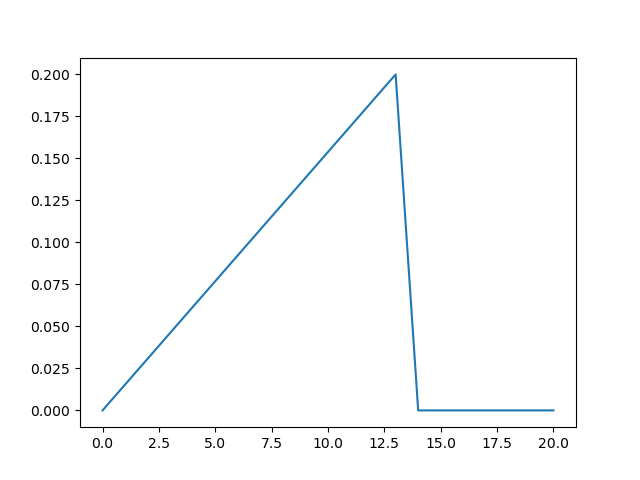

In [4]:
degrees = np.arange(1,22, dtype=float)
#degrees[0] = np.inf
power = np.flip(degrees**(-1))

power = np.hstack((np.linspace(0,0.2,14),np.linspace(0,0,7)))

plt.figure()
plt.plot(power)
plt.show()

<IPython.core.display.Javascript object>


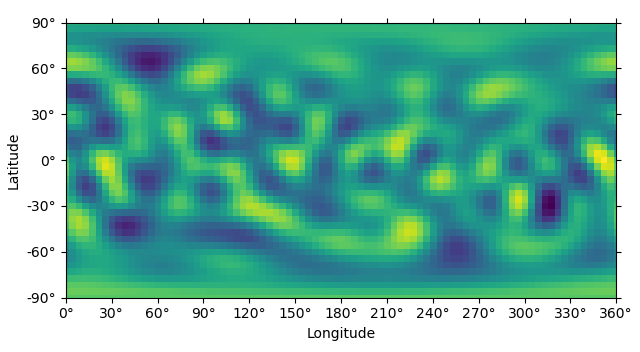

In [5]:
#rand_int = np.random.randint(0,99999)
rand_int = 67803
#print(rand_int)
clm = pyshtools.SHCoeffs.from_random(power, seed=rand_int)

grid = clm.expand()
fig, ax = grid.plot(show=False)

coeffs = clm.to_array(lmax=shn)

In [6]:
surface.data = pyshtools.expand.MakeGridGLQ(coeffs, surface.grid_zero, [surface.grid_nmax, 1, 1, shn, False]).reshape(-1,)
surface.target_var = np.var(surface.data)
surface.target_mean = 0.0

surface.g_prior, surface.g_prior_cilm = mt_util.sh_expand_glq(surface.data, 
                             surface.grid_nmax, surface.grid_w_shtools, surface.grid_zero, 
                             shn, geomag_scale = False)

np.testing.assert_allclose(surface.g_prior_cilm,coeffs)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 242 / 882 (27.4%)
Max absolute difference: 4.10782519e-15
Max relative difference: 6.46549956e-13
 x: array([[[-1.281057e-15,  0.000000e+00,  0.000000e+00,  0.000000e+00,
          0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
          0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,...
 y: array([[[-0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,...

In [7]:
print(surface)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Generate map for simple example
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             20
N_SH_secondary:   None
sim_type:         core
grid_zero:        (21,), Max/Min: 0.99 / -0.99
grid_w_shtools:   (21,), Max/Min: 0.15 / 0.02
grid_shape:       (2,), Max/Min: 41.00 / 21.00
grid_w:           (861,), Max/Min: 0.15 / 0.02
grid_radial:      (861,), Max/Min: 1.00 / 1.00
grid_theta:       (861,), Max/Min: 173.59 / 6.41
grid_phi:         (861,), Max/Min: 351.22 / 0.00
grid_N:           861
grid_nmax:        20
r_grid:           1
grid:             (861, 2)
sph_d:            (861, 861)
lon:              (861,), Max/Min: 351.22 / 0.00
lat:              (861,), Max/Min: 83.59 / -83.59
N_grid:           861
data:             (861,), Max/Min: 3.56 / -3.91
targe

In [8]:
surface.condtab(normsize=1000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101)

In [9]:
surface.attribute_string_update_print()


______new attributes______

CQF_dist:           (101, 101, 1000)
CQF_mean:           (101, 101)
CQF_var:            (101, 101)
rangv:              (101,), Max/Min: 2.00 / 0.00
rangn:              (101,), Max/Min: 3.50 / -3.50
condtab_normsize:   1000
condtab_model_hist: False
condtab_table:      rough



____semi-variogram setup___

Number of data used: 741321
Max data distance: 3.133 km
Lag length chosen: 0.1 km
Number of lags: 31
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


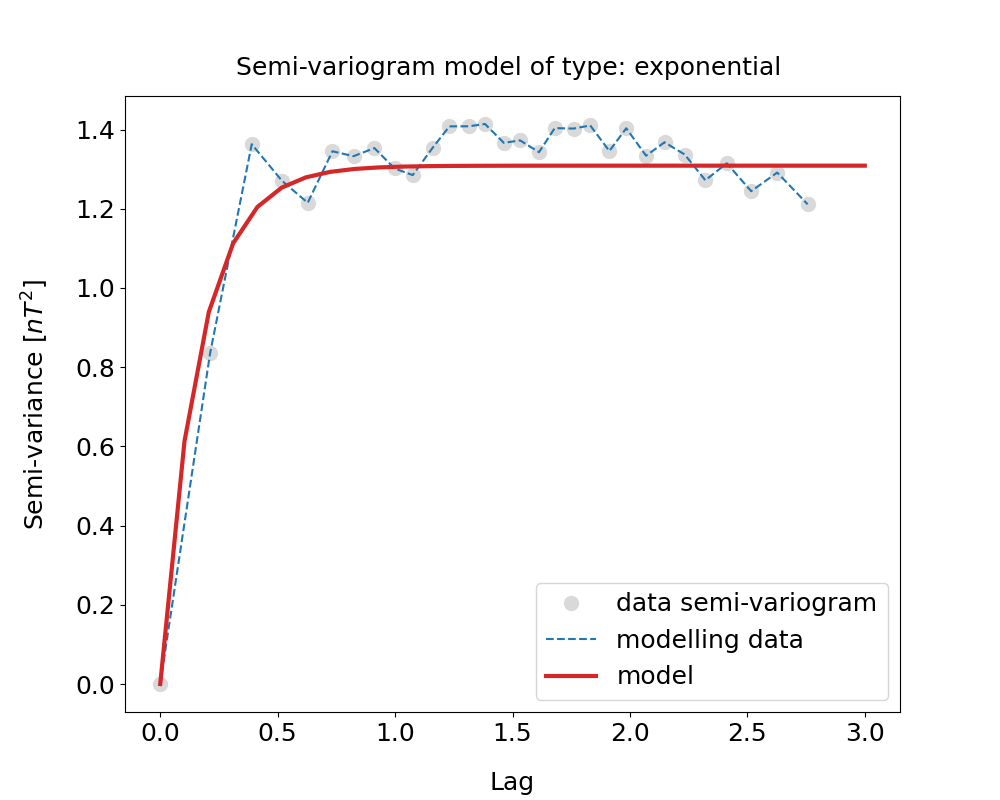

In [10]:
surface.semivar(model_lags = "all", model = "exponential", max_dist = 20, lag_length = 0.1,
             zero_nugget = True, hit_target_var = True)

#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(surface.lags,surface.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(surface.lags_model,surface.pics_model,'--',markersize=10,label='modelling data')
plt.plot(surface.lags_sv_curve,surface.sv_curve,color='C3', linewidth = 3,label='model')
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % surface.model_names[surface.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

# Synthetic observations

In [11]:
C_e_const = 10**(-6)

s_obs = SDSS(comment, N_SH = shn, sim_type = "random_obs")

s_obs.grid_equal_area(N_grid = 1000, r_at = 1)

grid_in = np.array([s_obs.grid_phi, 90-s_obs.grid_theta]).T
s_obs.make_grid(1, grid_in)

s_obs.r_grid = np.random.normal(loc=3.0, scale=0.5, size=(s_obs.N_grid,))

#s_sat.grid_equal_area(N_grid= 500, r_at = s_sat.r_sat, poles_remove = True)
#grid_in = np.array([s_sat.grid_eqa_phi, 90-s_sat.grid_eqa_theta]).T
#s_sat.grid(s_sat.r_sat, grid_in, calc_sph_d = False)

In [12]:
theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [90-surface.grid_theta.reshape(1,-1), 90-s_obs.grid_theta.reshape(-1,1), 
                                      surface.grid_phi.reshape(1,-1)-180, s_obs.grid_phi.reshape(-1,1)-180])
mu = np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)
    *np.sin(theta_s),np.cos(phi_d-phi_s))

mu.shape

(1000, 861)

In [13]:
kappa = 2
Tau = kappa/(4*np.pi*np.sinh(kappa))*np.exp(kappa*np.cos(mu))
Tau.shape

(1000, 861)

<IPython.core.display.Javascript object>


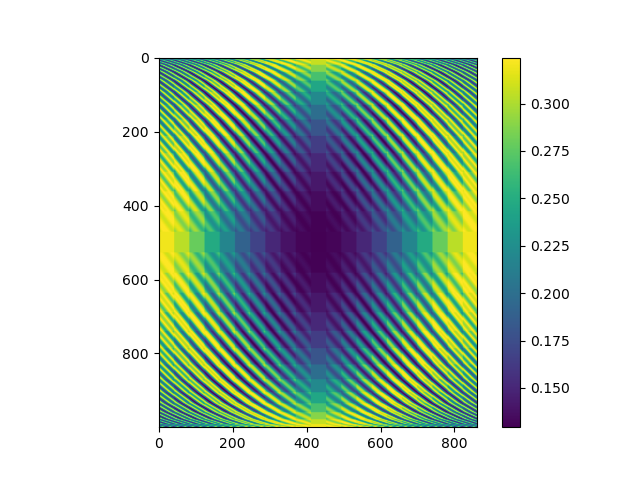

In [14]:
plt.figure()
plt.imshow(Tau)
plt.colorbar()
plt.show()

In [15]:
surface.G = np.pi/(surface.grid_nmax+0.5)*np.multiply(surface.grid_w,Tau) # +0.5 for parity with SHTOOLS

C_e = np.diag(C_e_const**2*np.ones(s_obs.N_grid,)) # No need to store C_e outside of here

surface.C_mm_all = surface.target_var-surface.sv_lut

surface.C_dm_all = surface.G@surface.C_mm_all

surface.C_dd = surface.C_dm_all@surface.G.T  + C_e

surface.C_dm_all = surface.C_dm_all.T

surface.C_e_const = C_e_const


s_obs.data = surface.G@surface.data

s_obs.data += np.random.normal(scale = C_e_const, size = s_obs.data.shape)

<IPython.core.display.Javascript object>


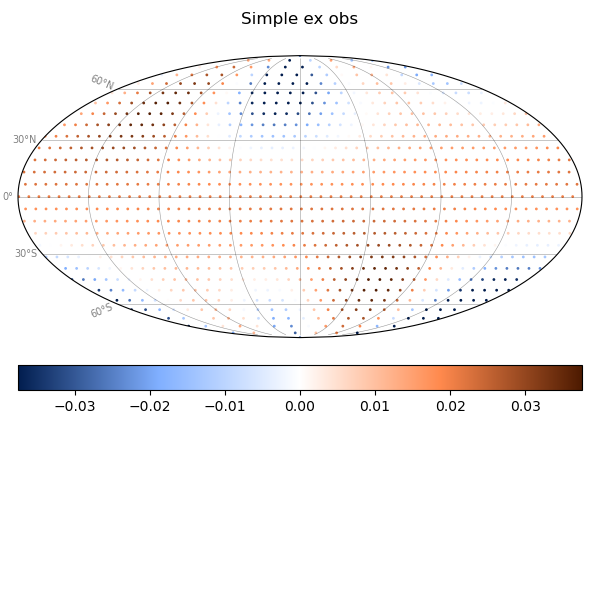

In [16]:
mt_util.plot_global(lat = s_obs.lat, lon = s_obs.lon, data=s_obs.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "", figsize=(6,6), coast_width = 0.0,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Simple ex obs', point_size=1,
                savefig = False, save_dpi = 100, save_string ="simple_ex_fischer_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 861/861, Running error magnitude: -0.2
Run time: 40.240 seconds 
Total elapsed time: 0.671 minutes 
Variance: 1.327
Mean: 0.061
Max: 3.185
Min: -3.927
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 861/861, Running error magnitude: -0.2
Run time: 45.348 seconds 
Total elapsed time: 1.426 minutes 
Variance: 1.314
Mean: 0.071
Max: 3.411
Min: -4.090
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 861/861, Running error magnitude: -0.2
Run time: 45.899 seconds 
Total elapsed time: 2.191 minutes 
Variance: 1.298
Mean: 0.062
Max: 3.496
Min: -4.136
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 861/861, Running error magnitude: -0.1
Run time: 45.927 seconds 
Total elapsed time: 2.957 minutes 
Variance: 1.354
Mean: 0.053
Max: 3.514
Min: -3.926
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4. Counter: 861/861, Running error magnitude: -0.2
Run time: 46.329 seconds 
Total elapsed time: 3.729 mi

<IPython.core.display.Javascript object>


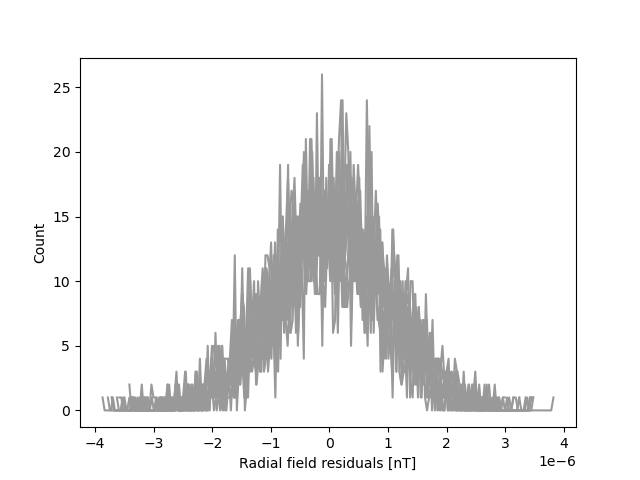

In [17]:
N_sim = 10

surface.run_sim(N_sim, surface.grid_N, surface.C_mm_all, surface.C_dd, surface.C_dm_all, surface.G,
        s_obs.data, surface.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho=True)

<IPython.core.display.Javascript object>


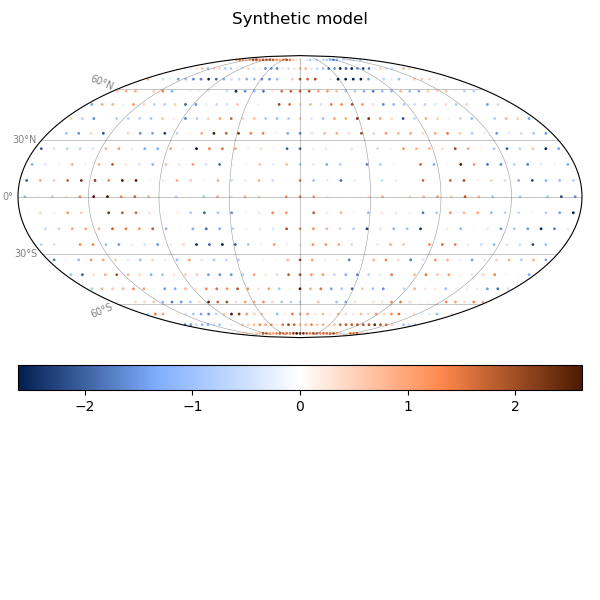

In [18]:
mt_util.plot_global(lat = surface.lat, lon = surface.lon, data=surface.m_DSS[:,0], 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "", figsize=(6,6), coast_width = 0.0,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Synthetic model', point_size=1,
                savefig = False, save_dpi = 100, save_string ="simple_ex_fischer",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [19]:
surface.realization_to_sh_coeff(1, set_nmax = shn, geomag_scale = False)

In [20]:
surface.covmod_lsq_equiv(s_obs.data, surface.C_mm_all, surface.G, 1.0, geomag_scale = False)

<IPython.core.display.Javascript object>


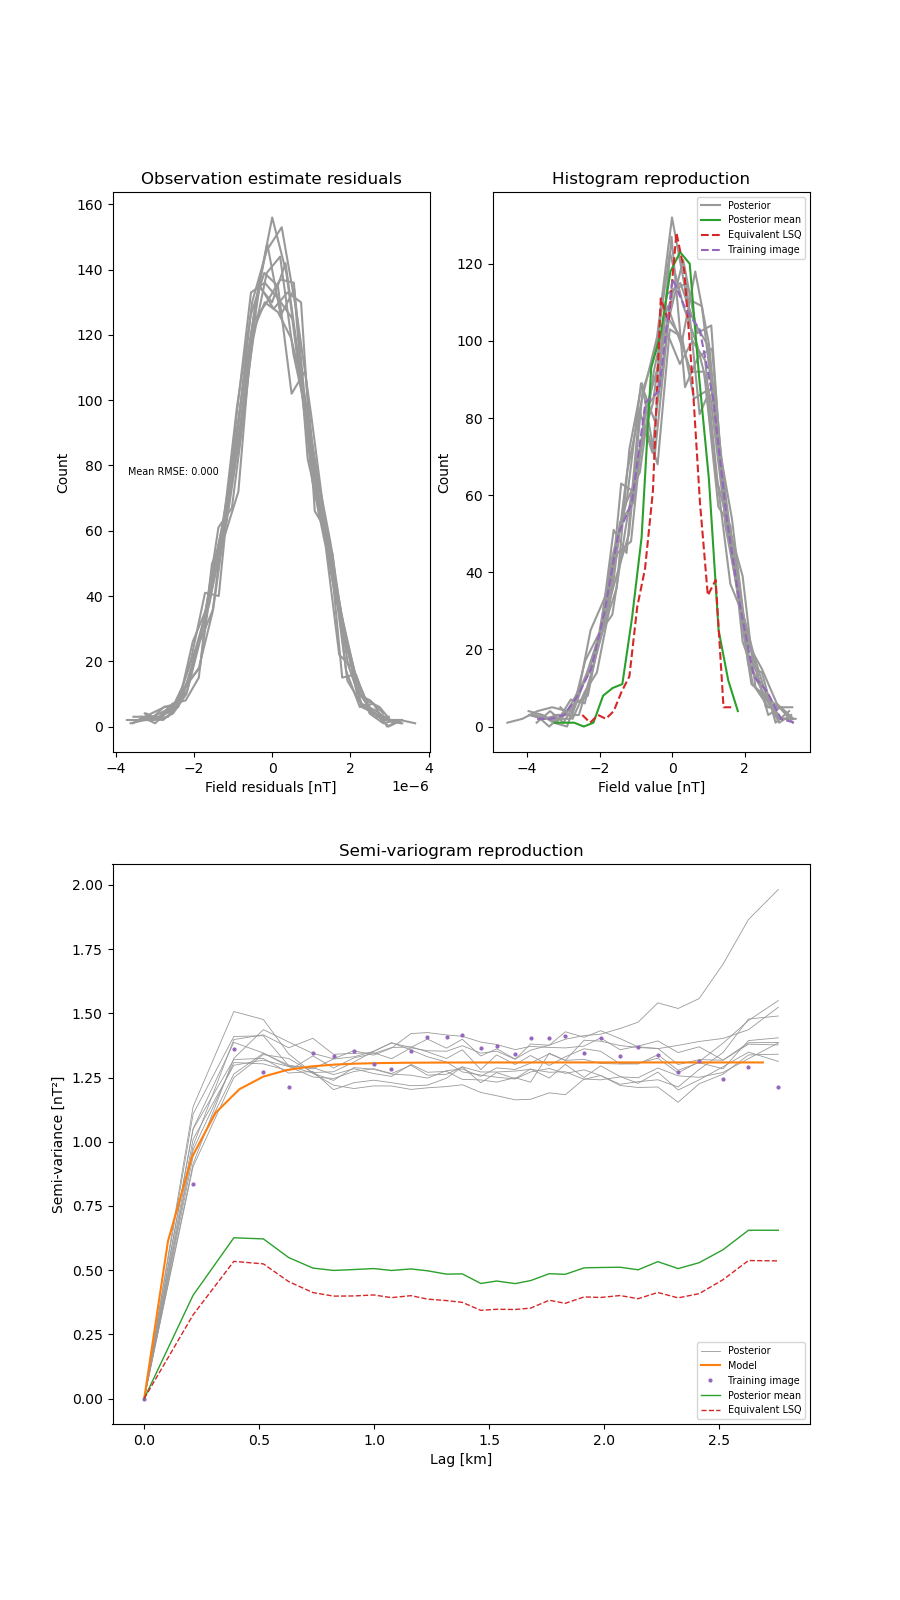

In [21]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

surface.grid_glq(nmax = shn, r_at = 1.0)
mt_util.plot_sdssim_reproduce(surface, surface.m_DSS_res, m_equiv_lsq = surface.m_equiv_lsq,
                              lags_use = 1000, spec_r_at = 1.0, spec_use = False,
                              model_dict = {}, figsize=(9,16),
                              hist_bins = 20, res_bins = 20,
                              savefig = False, save_string = "simple_ex", save_dpi = 100)

In [22]:
set_nmax = shn
r_at = 1.0

surface.grid_glq(nmax = 256, r_at = r_at)

zs_eqa = []
for i in np.arange(0,surface.g_spec.shape[1]):
    z_grid = mt_util.sh_makegrid_glq(surface.g_spec[:,i], surface.grid_nmax, surface.grid_zero, set_nmax)
    
    zs_eqa.append(z_grid.reshape(-1,))
    
zs_eqa = np.array(zs_eqa).T

zs_mean_eqa = mt_util.sh_makegrid_glq(surface.g_spec_mean, surface.grid_nmax, surface.grid_zero, set_nmax)

prior_eqa = mt_util.sh_makegrid_glq(surface.g_prior[:mt_util.shc_vec_len(set_nmax)], surface.grid_nmax, surface.grid_zero, set_nmax)

lsq_eqa = mt_util.sh_makegrid_glq(surface.g_lsq_equiv, surface.grid_nmax, surface.grid_zero, set_nmax)

<IPython.core.display.Javascript object>


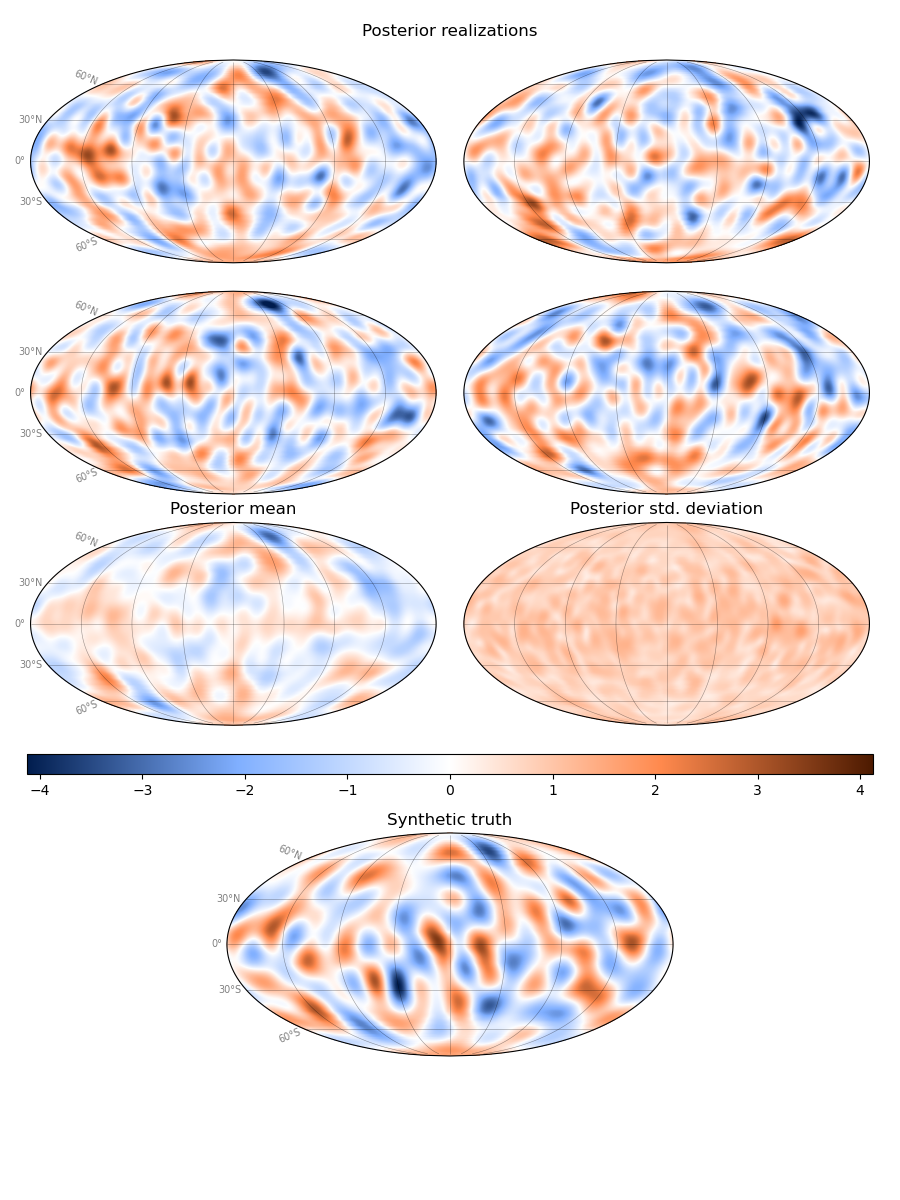

In [23]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(surface.grid_phi, 90-surface.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 1,
                        coast_width = 0.0, coast_color = "grey", unit_transform_n_to_m = False,
                        cbar_h = 0.1, cbar_text = "", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "simple_ex", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


In [ ]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")